In [1]:
import pickle
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import torch
import numpy as np

from utils import get_datasets, run_experiments, visualise_active_learning_experiments, visualise_most_and_least_informative_samples
from acquisition_functions import predictive_entropy, mutual_information, variation_ratios, mean_standard_deviation, random
from networks import LeNet

SEED = 1
MODEL_SAVE_PATH = '/Users/pascalpilz/Documents/Bsc Thesis/models/'

# Active Learning Experiments

In [2]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# this is the experiment template, for all actual experiments you should only change the acquisition function
base_experiment = {'acquisition_function': None,
                   'n_acquisition_steps': 2,
                   'n_samples_to_acquire': 10,
                   'n_epochs': 100}

random_params = base_experiment.copy()
random_params['acquisition_function'] = random

experiments = [random_params]
experiment_results, save_path = run_experiments(experiments, model_save_path=MODEL_SAVE_PATH, n_runs=2, seed=SEED)

Experiments:   0%|          | 0/1 [00:00<?, ?it/s]

Runs per Experiment:   0%|          | 0/2 [00:00<?, ?it/s]

Acquisition Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Training Epochs with Training size 20: 0it [00:00, ?it/s]

Training Epochs with Training size 30: 0it [00:00, ?it/s]

Training Epochs with Training size 40: 0it [00:00, ?it/s]

Acquisition Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Training Epochs with Training size 20: 0it [00:00, ?it/s]

Training Epochs with Training size 30: 0it [00:00, ?it/s]

Training Epochs with Training size 40: 0it [00:00, ?it/s]

/Users/pascalpilz/miniconda3/envs/al/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


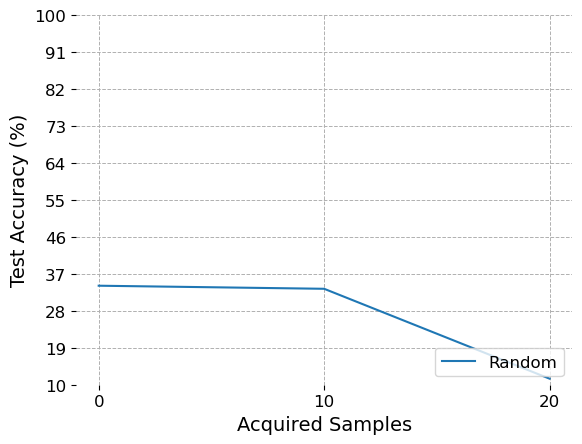

In [3]:
# save_path = './Experiment Results/exp_id-20240902_110408'
with open(save_path, 'rb') as handle:
    loaded_experiment_results = pickle.load(handle)

visualise_active_learning_experiments(loaded_experiment_results)

In [3]:
X_train, y_train, X_pool, y_pool, X_val, y_val, X_test, y_test = get_datasets()

subset_idx = np.random.choice(range(X_pool.shape[0]), size=5_000, replace=False)
X_pool_subset = X_pool[subset_idx]
y_pool_subset = y_pool[subset_idx]

In [4]:
path = MODEL_SAVE_PATH + 'expID-20240902_110347/run-0/random/trainsize-480_epoch-46'
model = LeNet()
model.load_state_dict(torch.load(path, weights_only=True))

<All keys matched successfully>

Predictive Entropy:   0%|          | 0/50 [00:00<?, ?it/s]

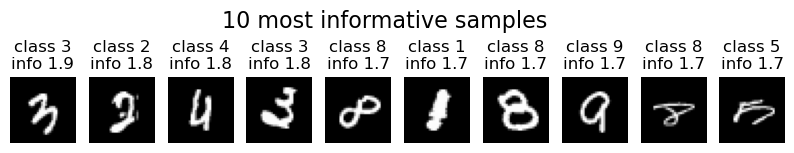

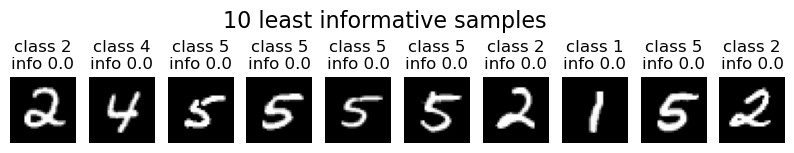

In [4]:
vals, subset_idx = predictive_entropy(model, X_pool_subset, show_pbar=True)
visualise_most_and_least_informative_samples(vals, X_pool_subset, y_pool_subset)

Mutual Information:   0%|          | 0/50 [00:00<?, ?it/s]

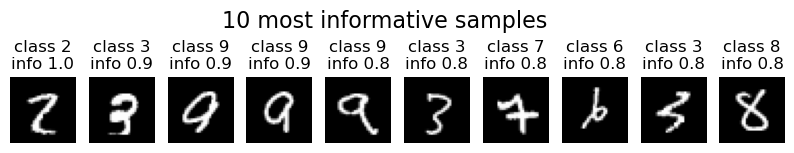

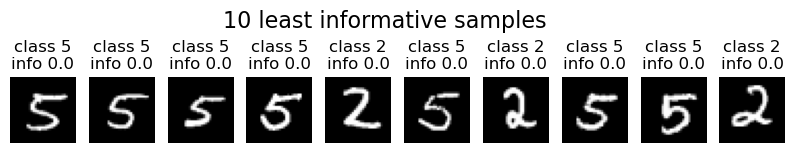

In [5]:
vals, subset_idx = mutual_information(model, X_pool_subset, show_pbar=True)
visualise_most_and_least_informative_samples(vals, X_pool_subset, y_pool_subset)

Mutual Information:   0%|          | 0/50 [00:00<?, ?it/s]

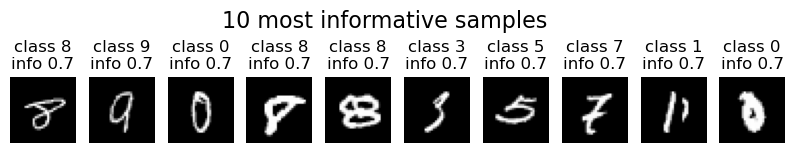

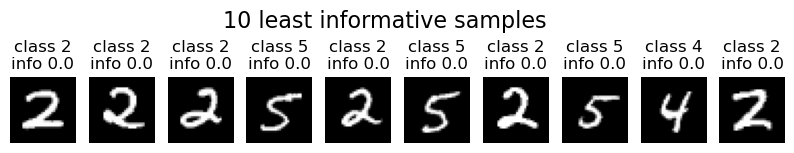

In [4]:
vals, subset_idx = variation_ratios(model, X_pool_subset, show_pbar=True)
visualise_most_and_least_informative_samples(vals, X_pool_subset, y_pool_subset)

Mutual Information:   0%|          | 0/50 [00:00<?, ?it/s]

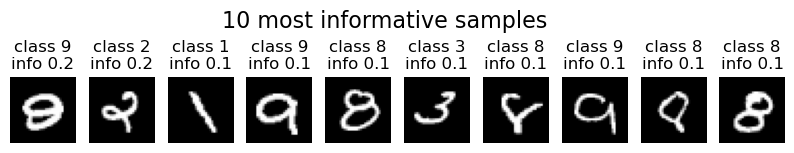

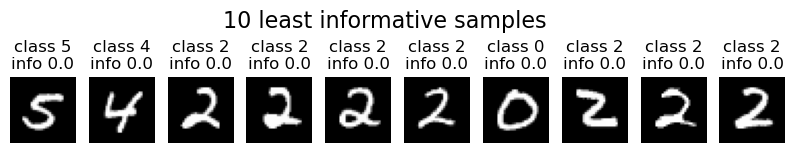

In [5]:
vals, subset_idx = mean_standard_deviation(model, X_pool_subset, show_pbar=True)
visualise_most_and_least_informative_samples(vals, X_pool_subset, y_pool_subset)

In [24]:
dataset = torch.utils.data.TensorDataset(X_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4)

torch.concat([torch.concat(elem) for elem in list(iter(data_loader))]).shape
# [elem for elem in iter(data_loader)]

torch.Size([20, 1, 32, 32])